<a href="https://colab.research.google.com/github/65-1157/Aplica-o_NLP_instrumentos_musicais/blob/main/5123_KNN_Instrumentos_Musicais_varia%C3%A7ao_K_Andr%C3%A9_Marques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1_Preparação_ferramentas



Importação_bibliotecas





In [ ]:
import numpy as np
import itertools
import pandas as pd
# System
import os, fnmatch
# visualização
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display
# Aprendizado_máquina
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
# Dados_aleatórios
from numpy.random import seed
seed(1)
# biblioteca_audio
import librosa.display, librosa

In [ ]:
# gerenciamento_alarmes
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# exibição_website
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

2_Dataset_Detalhes_Gerais

In [ ]:
# informação_geral_dataset
show_web("https://www.philharmonia.co.uk/resources/sound-samples/")


Arquivo_dataset_Phillarmonica

In [ ]:
!git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
!unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# pegar_audios
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("encontrados %d audio_arquivos: %s"%(len(files),path))

Cloning into 'BasicsMusicalInstrumClassifi'...
remote: Enumerating objects: 904, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 904 (delta 3), reused 0 (delta 0), pack-reused 895
Receiving objects: 100% (904/904), 14.10 MiB | 31.95 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Archive:  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi.zip
   creating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/mfcc_feature_vectors.pl  
 extracting: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/max_length.pl  
   creating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Ds3_05_fortissimo_arco-normal.mp3  
  inflating: ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_A

Carregar_nomes

In [ ]:
# Carregamento_identificação
labels =[]
classes=['flute','sax','oboe', 'cello','trumpet','viola']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

Atribuir_rótulos_labels

In [ ]:
# Alocação_labels_encoders
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


Parâmetros_processamento

In [ ]:
# Parâmetros
fs = 96000        # frequência_amostragem
n_fft = 2048       # janela_FFT_será_alterado
hop_length = 512   # Hop_será_alterado
n_mels = 128       # MEL bands_inalterado
n_mfcc = 13        # MFCCs_inalterado

# Geral_Aprendizado_Máquina
testset_size = 0.25 # Limite_corte_teste_treino
n_neighbors=1       # qte_vizinhos_será_alterado

Funções_cálculo

In [ ]:
# Cálculo: MFCC 
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

In [ ]:
# Operação_dados_cálculo_features_feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("colhido %d de %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() # normalização pelo valor máximo (razão_será_<1)
        if len(y) < 2:
            print("Erro_carregamento %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Erro_carregamento %s. Error: %s" % (f,e))
        
print("Cálculos %d feature_vectors"%len(feature_vectors))

colhido 1 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_025_forte_normal.mp3
colhido 2 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_E3_025_pianissimo_normal.mp3
colhido 3 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_1_pianissimo_normal.mp3
colhido 4 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_B3_025_forte_normal.mp3
colhido 5 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_E3_15_pianissimo_normal.mp3
colhido 6 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_F3_025_forte_normal.mp3
colhido 7 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_05_forte_normal.mp3
colhido 8 de 600 = ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_B3_1_pianissimo_normal.mp3

In [ ]:
# Alteração_dados_com_StandardScaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Formato_feature_vectors:",scaled_feature_vectors.shape)

Formato_feature_vectors: (600, 13)


In [ ]:
df=pd.DataFrame(scaled_feature_vectors)

In [ ]:
df.head(2) #exibição dos 13 MFCCs

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.857396,-1.655263,-0.637387,-0.558864,-0.538963,-1.549352,-0.930736,-0.655931,-0.920239,0.501059,0.644314,0.637955,0.642765
1,-2.360356,-0.337125,1.337035,0.484142,0.838986,0.306487,-0.025231,0.300936,0.090531,1.072563,0.453449,-0.108111,-0.205065


In [ ]:
df1=pd.DataFrame(classes_num)
df1.head(2)

,0
0,4
1,4


Data_Frame_Análise_Exploratória_junção_dois_arrays

In [ ]:
df2=pd.concat([df,df1],axis=1)
df2.tail(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,0
598,0.137803,-0.806585,0.055134,0.382848,-0.363134,-0.150792,-0.074248,-0.019717,0.058375,0.543413,0.964323,0.620400,0.498315,1
599,1.321960,-0.142660,-0.402662,0.706745,-1.837702,0.073494,-0.473307,-0.206435,0.669691,0.284914,1.853749,1.230709,1.705264,1


In [ ]:
# seleção dos 5 MFCCs mais importantes, após feature_importance
df2.columns=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','classe']
df3 = df2.iloc[:,8:14]
df3.tail(2)

,c8,c9,c10,c11,c12,classe
598,0.058375,0.543413,0.964323,0.620400,0.498315,1
599,0.669691,0.284914,1.853749,1.230709,1.705264,1


Separação_treino_teste

In [ ]:
X = df3.iloc[:,0:5]
y = df3.iloc[:,5]
X.shape

(600, 5)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

Menor_taxa_erro:- 0.20666666666666667 com K = 2


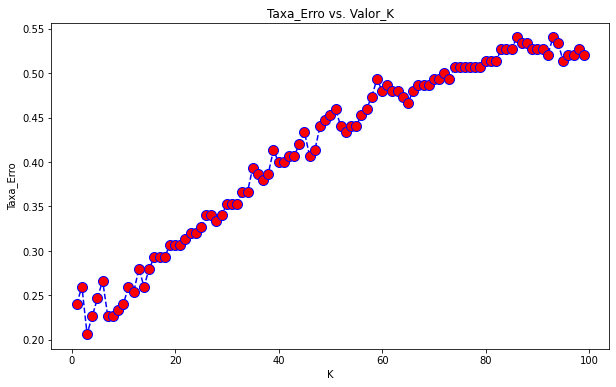

In [ ]:
error_rate = []
for i in range(1,100):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Taxa_Erro vs. Valor_K')
plt.xlabel('K')
plt.ylabel('Taxa_Erro')
print("Menor_taxa_erro:-",min(error_rate),"com K =",error_rate.index(min(error_rate)))

F1_score_máximo:- 0.7430127506634955 com K = 2


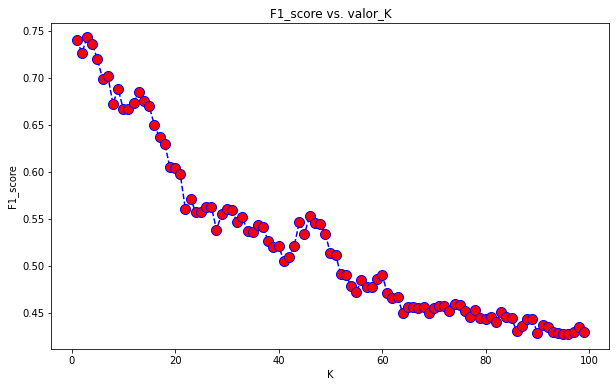

In [ ]:
f1_score = []
from sklearn import metrics
for i in range(1,100):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    f1_score.append(metrics.f1_score(y_test, yhat, average='weighted'))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,100),f1_score,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('F1_score vs. valor_K')
plt.xlabel('K')
plt.ylabel('F1_score')
print("F1_score_máximo:-",max(f1_score),"com K =",f1_score.index(max(f1_score)))

Métricas

Matriz de Confusão

In [ ]:
# Execução_Matriz_Confusão
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

Plotagem_Matriz

In [ ]:
# Plotagem_Matriz_Confusão
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("matriz_confusão_normalizada")
    else:
        print('matriz_confusão_não_normalizada')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

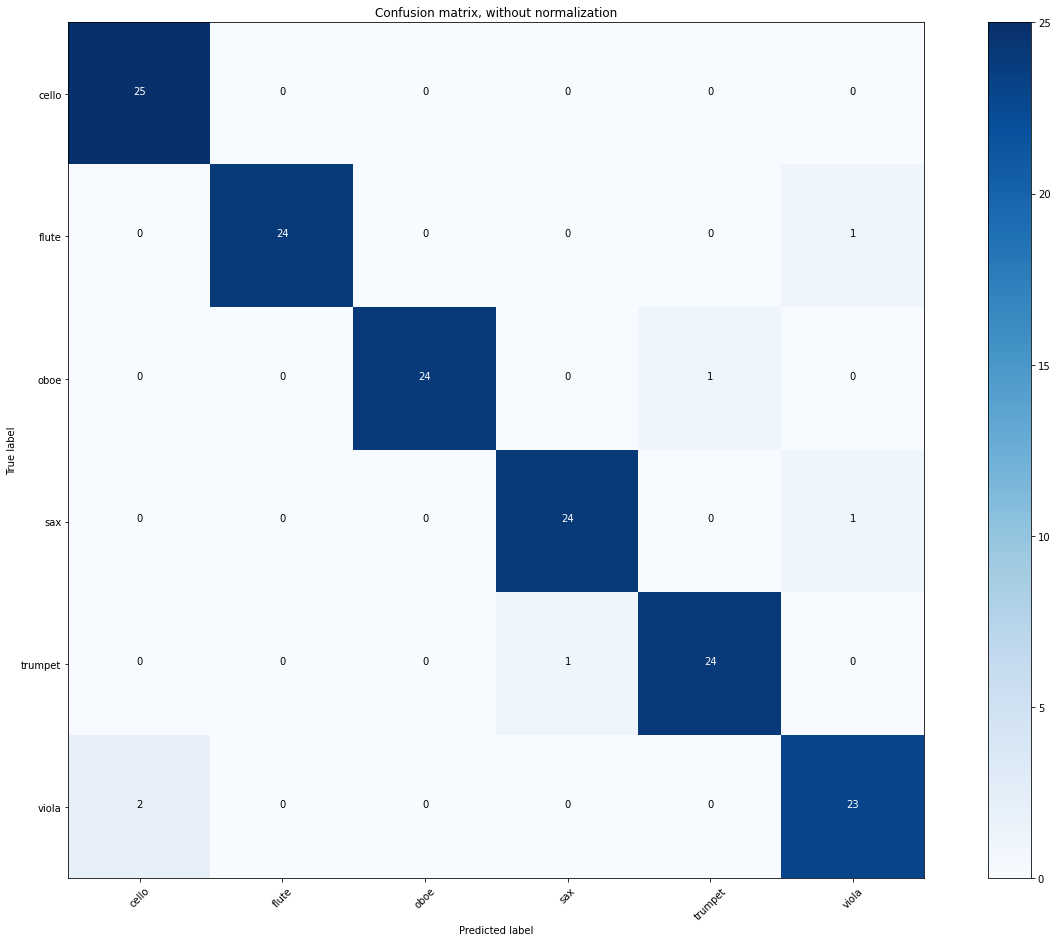

In [ ]:
# MC_não_normalizada
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='matriz_confusão_sem_normalização')

Valores_preditos_erroneamente

In [ ]:
# Exemplos_preditos_incorretamente
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Predições_incorretas
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['sax' 'sax' 'viola' 'oboe' 'oboe' 'cello' 'sax' 'sax' 'viola' 'viola'
 'cello']
[4 5 4 4 4 5 5 4 0 0 5]
['trumpet' 'viola' 'trumpet' 'trumpet' 'trumpet' 'viola' 'viola' 'trumpet'
 'cello' 'cello' 'viola']
['./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds5_1_forte_minor-trill.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_pianissimo_subtone.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs5_1_fortissimo_snap-pizz.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/oboe/oboe_As3_15_mezzo-forte_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/oboe/oboe_As3_1_mezzo-forte_normal.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-forte_arco-harmonic.mp3'
 './BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_pianissimo_normal.mp3'
 './BasicsMusicalInstrumCla